## This is an attempt to implement other neighborhood operators
From section 3.3 of Computer Vision - Algorithms and Applications 2nd Edition, Richard Szeliski

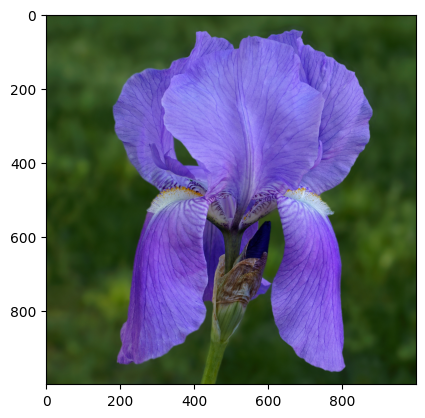

In [ ]:
# Load image Iris.jpg
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the image
image = cv2.imread('dat/Iris.jpg')
# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Display the image using matplotlib
plt.imshow(image_rgb)


## 3.3.1 Non-linear filtering
### Median filtering of salt and pepper noise

- The shot noise in the book seems to be referring to salt and pepper noise.

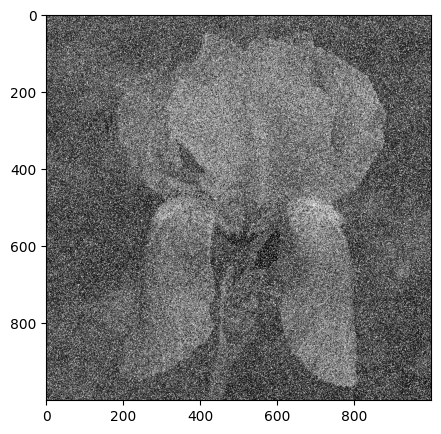

In [115]:
# Convert the image to grayscale
image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
noise_img = image.copy()

# Add salt-and-pepper noise
noise_ratio = 0.4  # 5% of pixels will be affected
num_pixels = int(noise_ratio * noise_img.size)

# Randomly select pixel indices
indices = np.random.choice(noise_img.size, num_pixels, replace=False)
coords = np.unravel_index(indices, noise_img.shape)

# Randomly set to 0 (pepper) or 255 (salt)
salt_pepper = np.random.choice([0, 255], size=num_pixels)
noise_img[coords[0], coords[1]] = salt_pepper

# Display the noisy image
plt.figure(figsize=(10, 5))
plt.imshow(noise_img, cmap='gray')

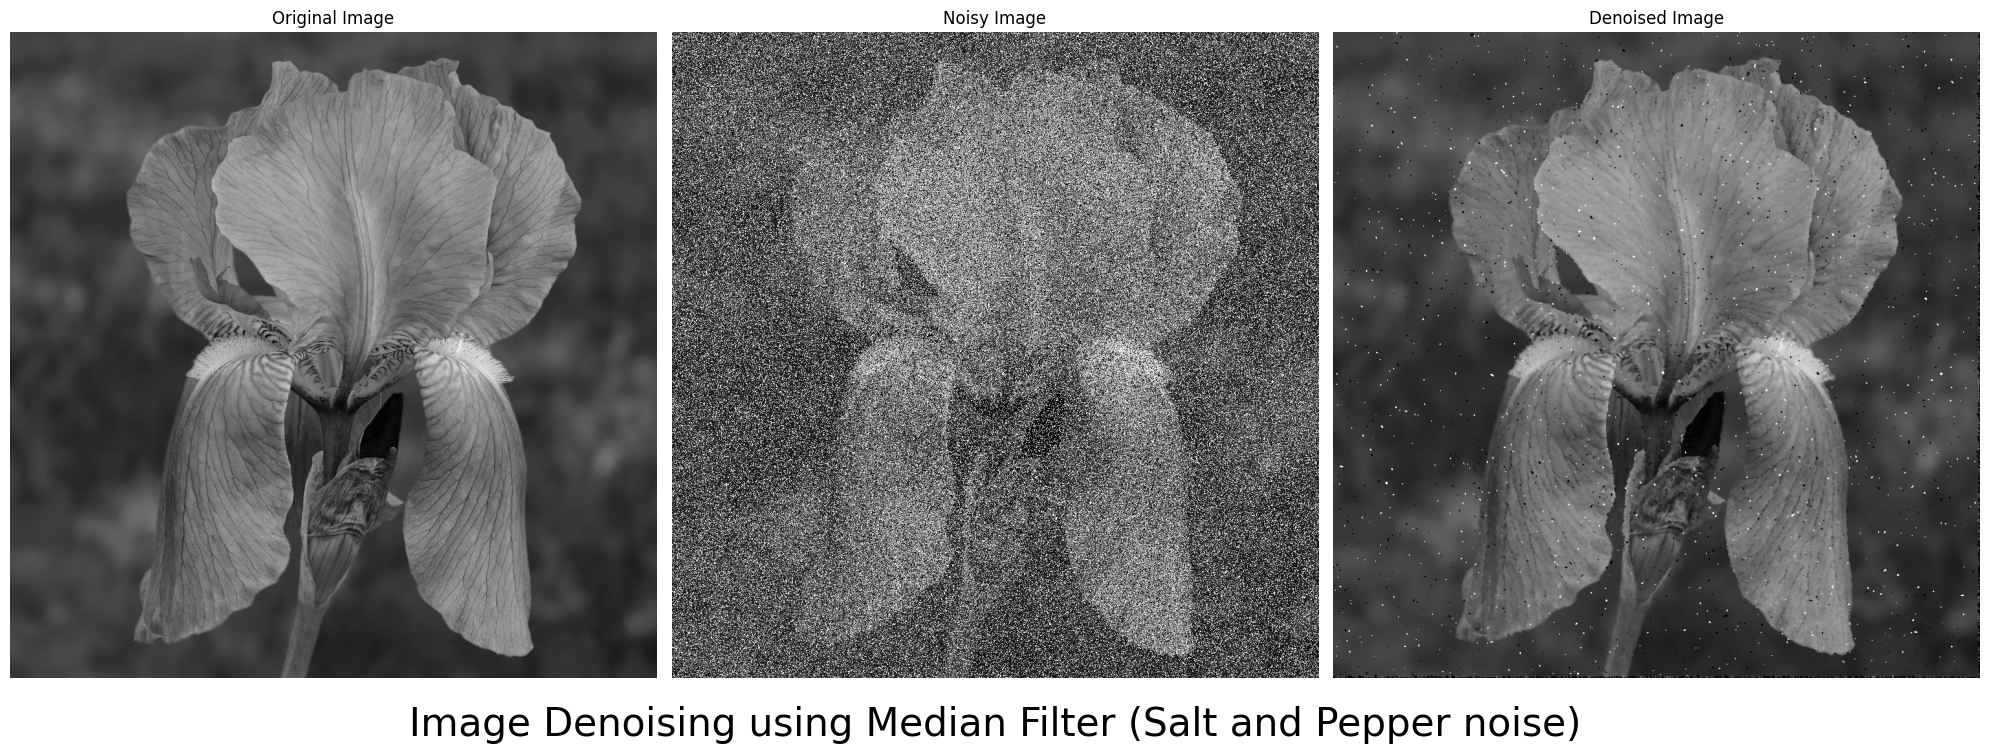

In [116]:
noise = noise_img.copy()

length = 3
pad = length // 2
# padding
noise = cv2.copyMakeBorder(noise, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=0)
for i in range(pad, noise.shape[0] - pad):
    for j in range(pad, noise.shape[1] - pad):
        # Extract the neighborhood
        neighborhood = noise[i - pad:i + pad + 1, j - pad:j + pad + 1]
        # Sort the neighborhood pixels
        sorted_pixels = np.sort(neighborhood, axis=None)
        # Median value
        median_value = sorted_pixels[length * length // 2]
        # Set the pixel to the median value
        noise[i - pad, j - pad] = median_value
for i in range(pad, noise.shape[0] - pad):
    for j in range(pad, noise.shape[1] - pad):
        # Extract the neighborhood
        neighborhood = noise[i - pad:i + pad + 1, j - pad:j + pad + 1]
        # Sort the neighborhood pixels
        sorted_pixels = np.sort(neighborhood, axis=None)
        # Median value
        median_value = sorted_pixels[length * length // 2]
        # Set the pixel to the median value
        noise[i - pad, j - pad] = median_value

# Display the denoised image
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(noise_img, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(noise, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')
plt.tight_layout(h_pad=0.5)
# Add text below the images
plt.figtext(0.5, 0.12, 'Image Denoising using Median Filter (Salt and Pepper noise)', ha='center', fontsize=28)
plt.show()


**TODO** : Implementing $\alpha$-trimmed mean and weighted median.

### 3.3.2 Bilateral filtering of Gaussian noise
- combining the idea of a weighted filter kernel with a better version of outlier
 rejection

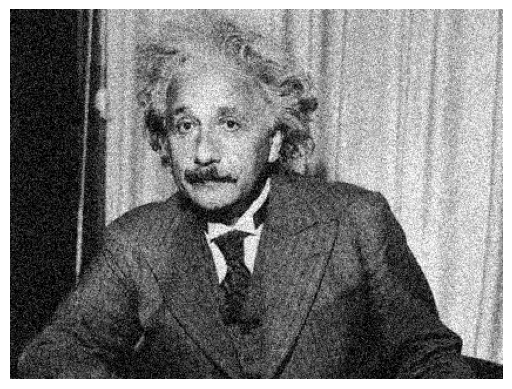

In [ ]:
# Load black-and-white image as grayscale
img = cv2.imread('dat/einstein.png', cv2.IMREAD_GRAYSCALE)
noise = img.astype(float)  # Convert to float for noise addition

# Add Gaussian noise
mean = 0
stddev = 25  # Adjust stddev for visible noise (0.7 is too low for uint8 range)
gaussian_noise = np.random.normal(mean, stddev, img.shape)
noise = noise + gaussian_noise

# Clip to valid uint8 range [0, 255]
noise = np.clip(noise, 0, 255).astype(np.uint8)
# convert to [0, 1] 
noise = noise / 255.0

# Display the noisy image
plt.figure()
plt.imshow(noise, cmap='gray')
plt.axis('off')
plt.show()

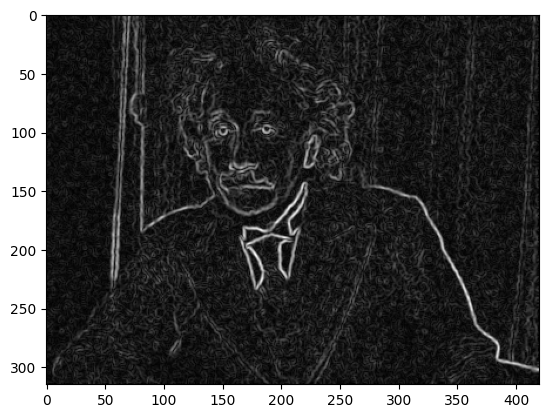

In [118]:
# apply sobel filter on the noisy image
sobel_x = cv2.Sobel(noise, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(noise, cv2.CV_64F, 0, 1, ksize=5)
# Combine the two gradients
sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
# Normalize the result to [0, 1]
sobel_combined = cv2.normalize(sobel_combined, None, 0, 1, cv2.NORM_MINMAX)
# Display the Sobel filtered image
plt.figure()
plt.imshow(sobel_combined, cmap='gray')


Domain Kernel:
 [[1.7910637e-08 5.9311884e-07 7.2256666e-06 3.2383192e-05 5.3390853e-05
  3.2383192e-05 7.2256666e-06 5.9311884e-07 1.7910637e-08]
 [5.9311884e-07 1.9641397e-05 2.3928120e-04 1.0723840e-03 1.7680622e-03
  1.0723840e-03 2.3928120e-04 1.9641397e-05 5.9311884e-07]
 [7.2256666e-06 2.3928120e-04 2.9150420e-03 1.3064311e-02 2.1539407e-02
  1.3064311e-02 2.9150420e-03 2.3928120e-04 7.2256666e-06]
 [3.2383192e-05 1.0723840e-03 1.3064311e-02 5.8550183e-02 9.6532933e-02
  5.8550183e-02 1.3064311e-02 1.0723840e-03 3.2383192e-05]
 [5.3390853e-05 1.7680622e-03 2.1539407e-02 9.6532933e-02 1.5915589e-01
  9.6532933e-02 2.1539407e-02 1.7680622e-03 5.3390853e-05]
 [3.2383192e-05 1.0723840e-03 1.3064311e-02 5.8550183e-02 9.6532933e-02
  5.8550183e-02 1.3064311e-02 1.0723840e-03 3.2383192e-05]
 [7.2256666e-06 2.3928120e-04 2.9150420e-03 1.3064311e-02 2.1539407e-02
  1.3064311e-02 2.9150420e-03 2.3928120e-04 7.2256666e-06]
 [5.9311884e-07 1.9641397e-05 2.3928120e-04 1.0723840e-03 1.7680622

(np.float64(-0.5), np.float64(419.5), np.float64(314.5), np.float64(-0.5))

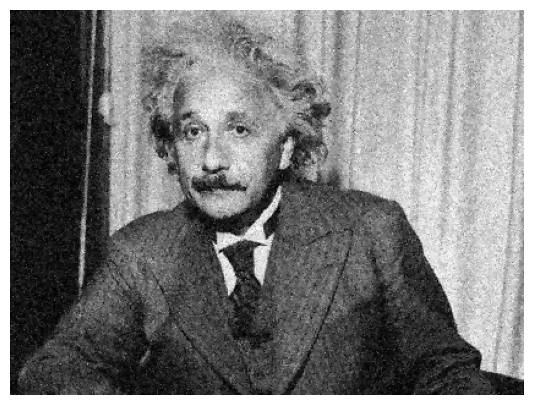

In [119]:
g = noise.copy()
res = np.zeros(noise.shape, dtype=np.float32)
d = 9
pad = d // 2
# padding
g = cv2.copyMakeBorder(g, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=0)

sigma_domain = 1.0
sigma_range = 0.1
# domain kernel
domain_kernel = np.zeros((d, d), dtype=np.float32)
for i in range(-pad, pad + 1):
    for j in range(-pad, pad + 1):
        domain_kernel[i + pad, j + pad] = np.exp(-(i**2 + j**2) / (2 * sigma_domain**2))
domain_kernel /= np.sum(domain_kernel)
print("Domain Kernel:\n", domain_kernel)

for i in range(pad, g.shape[0] - pad):
    for j in range(pad, g.shape[1] - pad):
        block = g[i - pad:i + pad + 1, j - pad:j + pad + 1]
        center = block[pad, pad]

        # range kernel
        range_kernel = np.zeros((d, d), dtype=np.float32)
        for k in range(-pad, pad + 1):
            for l in range(-pad, pad + 1):
                diff = center - block[k + pad, l + pad]
                range_kernel[k + pad, l + pad] = np.exp(-(diff**2) / (2 * sigma_range**2))
        range_kernel /= np.sum(range_kernel)

        # weight kernel
        weight_kernel = domain_kernel * range_kernel
        weight_kernel /= np.sum(weight_kernel)

        # print(weight_kernel.shape)
        # print(block.shape)
        # convert the block to grayscale
        # block = cv2.cvtColor(block, cv2.COLOR_RGB2GRAY)
        res[i - pad, j - pad] = np.sum(weight_kernel * block) / np.sum(weight_kernel)
res = res / np.max(res)

# Display the denoised image
plt.figure(figsize=(10, 5))
plt.imshow(res, cmap='gray')
plt.axis('off')

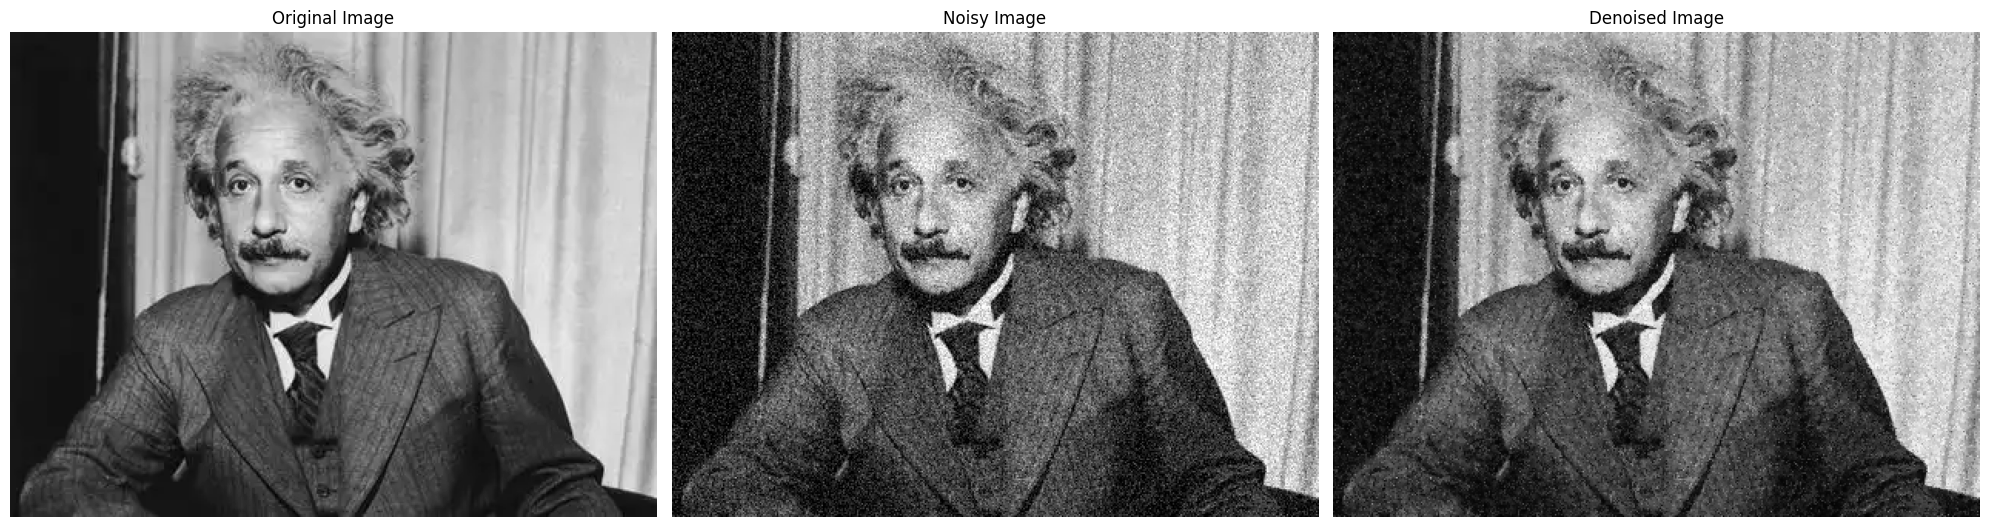

In [120]:
# show the original, noisy, and denoised images
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(noise, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(res, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')
plt.tight_layout(h_pad=0.5)

- I could not get the bilateral filter to work properly, some flaws like normalization pre-maturely, etc were there. Corrected code with Gemini below:

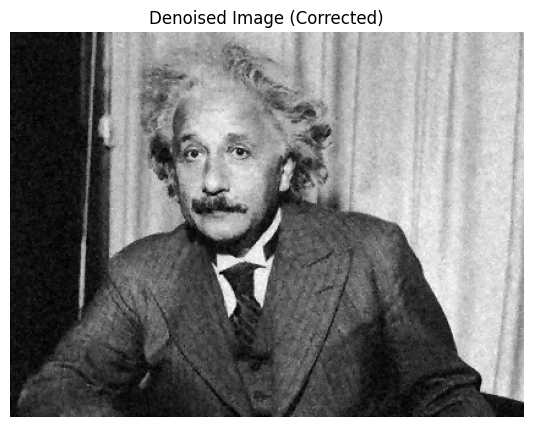

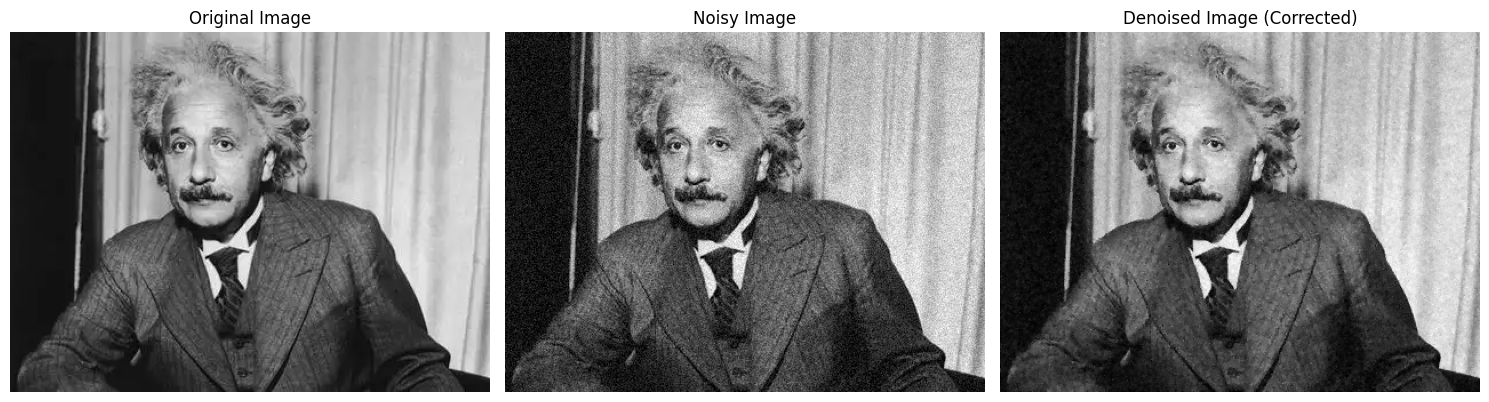

In [ ]:
# Load black-and-white image as grayscale
img = cv2.imread('dat/einstein.png', cv2.IMREAD_GRAYSCALE)
noise_orig_scale = img.astype(float)  # Convert to float for noise addition

# Add Gaussian noise
mean = 0
stddev = 15
gaussian_noise = np.random.normal(mean, stddev, img.shape)
noise_orig_scale = noise_orig_scale + gaussian_noise

# Clip to valid uint8 range [0, 255]
noise_uint8 = np.clip(noise_orig_scale, 0, 255).astype(np.uint8)
# convert to [0, 1]
noise_norm = noise_uint8 / 255.0

# Display the noisy image (optional)
# plt.figure(figsize=(10, 5))
# plt.imshow(noise_norm, cmap='gray')
# plt.axis('off')
# plt.show()

g_noisy_norm = noise_norm.copy()
res = np.zeros(g_noisy_norm.shape, dtype=np.float32)
d = 9  # Diameter of the pixel neighborhood
pad = d // 2

# Padding
g_padded = cv2.copyMakeBorder(g_noisy_norm, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=0)

sigma_domain = 1.0  # You might also experiment with this, e.g., 2.0 or 3.0 for d=9
sigma_range = 0.1   # ADJUSTED sigma_range

# Domain kernel (spatial weights - calculated once, unnormalized)
domain_kernel = np.zeros((d, d), dtype=np.float32)
for i_offset in range(-pad, pad + 1):
    for j_offset in range(-pad, pad + 1):
        domain_kernel[i_offset + pad, j_offset + pad] = np.exp(-(i_offset**2 + j_offset**2) / (2 * sigma_domain**2))
# REMOVED: domain_kernel /= np.sum(domain_kernel)
# print("Unnormalized Domain Kernel (first 3x3):\n", domain_kernel[:3,:3])


# Main filtering loop
for r_center_padded in range(pad, g_padded.shape[0] - pad):  # Row of the center pixel in the padded image
    for c_center_padded in range(pad, g_padded.shape[1] - pad): # Col of the center pixel in the padded image
        # Extract the current window/block from the padded image
        block = g_padded[r_center_padded - pad : r_center_padded + pad + 1, \
                         c_center_padded - pad : c_center_padded + pad + 1]
        # Get the intensity of the center pixel of the window
        center_pixel_value = g_padded[r_center_padded, c_center_padded]

        # Range kernel (intensity weights - calculated for each window, unnormalized)
        range_kernel = np.zeros((d, d), dtype=np.float32)
        for k_block_row in range(d):  # Row index within the block (0 to d-1)
            for l_block_col in range(d): # Col index within the block (0 to d-1)
                neighbor_pixel_value = block[k_block_row, l_block_col]
                intensity_difference_sq = (center_pixel_value - neighbor_pixel_value)**2
                range_kernel[k_block_row, l_block_col] = np.exp(-(intensity_difference_sq) / (2 * sigma_range**2))
        # REMOVED: range_kernel /= np.sum(range_kernel)

        # Bilateral weight kernel (product of domain and range kernels)
        bilateral_weight_kernel = domain_kernel * range_kernel
        # REMOVED: weight_kernel /= np.sum(weight_kernel) # This normalization was redundant with the next step

        # Calculate the sum of all bilateral weights in the current window
        sum_of_bilateral_weights = np.sum(bilateral_weight_kernel)

        # Apply the filter for the current center pixel
        # Output coordinates in the result image (unpadded)
        r_out = r_center_padded - pad
        c_out = c_center_padded - pad

        if sum_of_bilateral_weights > 1e-6:  # Avoid division by zero or very small numbers
            filtered_pixel_value = np.sum(bilateral_weight_kernel * block) / sum_of_bilateral_weights
            res[r_out, c_out] = filtered_pixel_value
        else:
            # If all weights are zero (e.g., sigma_range is tiny and all neighbors are too different),
            # fall back to the original (noisy) pixel value.
            res[r_out, c_out] = center_pixel_value

# Normalize the result image to [0, 1] for display, if necessary.
# Values should ideally be in [0,1] already, but this handles any minor floating point overflows.
max_val = np.max(res)
if max_val > 0:
    res = res / max_val
res = np.clip(res, 0, 1)


# Display the denoised image
plt.figure(figsize=(10, 5))
plt.imshow(res, cmap='gray')
plt.title('Denoised Image (Corrected)')
plt.axis('off')
plt.show()

# Show the original, noisy, and denoised images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray') # Original clean image
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(noise_norm, cmap='gray') # Noisy image (normalized [0,1])
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(res, cmap='gray') # Denoised image
plt.title('Denoised Image (Corrected)')
plt.axis('off')

plt.tight_layout(h_pad=0.5)
plt.show()

Regarding guided image filtering, one of my ideas was to use sobel filters on the noisy image and then we would find the edges and use it as a guide. But results show that using sobel on noisy image is practically useless.

### **TODO** : Read the paper K., Sun, J., and Tang, X. (2013). Guided image filtering. IEEE Transactions on Pattern Analysis and Machine Intelligence, 35(6):1397–1409.

### 3.3.3 Binary Image Processing

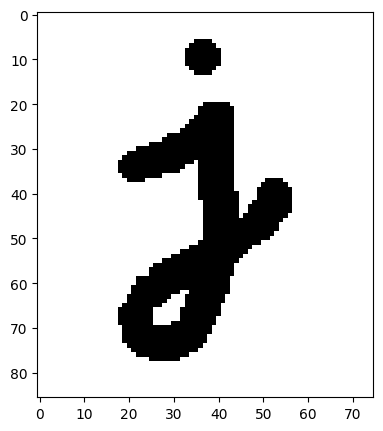

In [ ]:
image = cv2.imread('dat/binary_image.png', cv2.IMREAD_GRAYSCALE)
image = image / 255.0
plt.figure(figsize=(10, 5))
plt.imshow(image, cmap='gray')

(np.float64(-0.5), np.float64(74.5), np.float64(85.5), np.float64(-0.5))

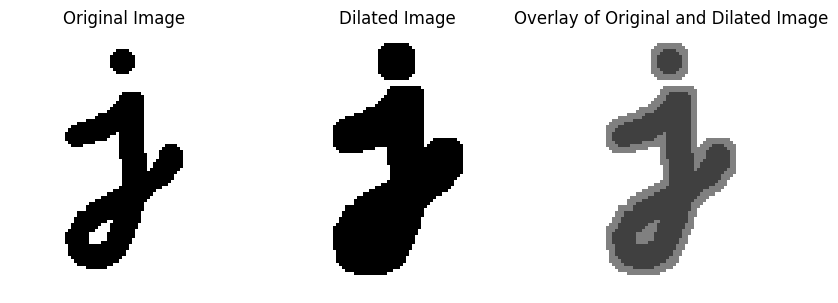

In [123]:
# invert the image
img = image.copy()
img = 1 - img

def threshold(arg1, arg2):
    if arg1 >= arg2:
        return 1
    else:
        return 0
    
def dialation(image, kernel, pad):
    # image already inverted
    padded_image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    output_image = np.zeros_like(image)
    for i in range(pad, padded_image.shape[0] - pad):
        for j in range(pad, padded_image.shape[1] - pad):
            block = padded_image[i - pad:i + pad + 1, j - pad:j + pad + 1]
            c = np.sum(block * kernel)
            output_image[i - pad, j - pad] = threshold(c, 1)
    return output_image

ker = np.zeros((5, 5), dtype=np.float32) + 1
ker_len = ker.shape[0]
pad = ker_len // 2
# Perform dilation
dilated_image = dialation(img, ker, pad)
dilated_image = 1- dilated_image  # Re-invert the image for display purposes
# Display the dilated image vs original
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(1-img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(dilated_image, cmap='gray')
plt.title('Dilated Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(1-img, cmap='gray', alpha=0.5)
plt.imshow(dilated_image, cmap='gray', alpha=0.5)
plt.title('Overlay of Original and Dilated Image')
plt.axis('off')
            

(np.float64(-0.5), np.float64(74.5), np.float64(85.5), np.float64(-0.5))

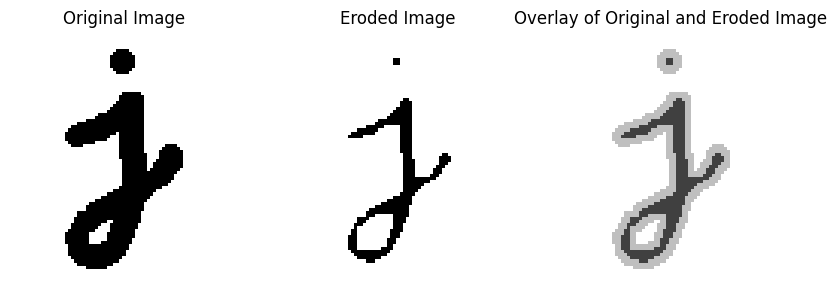

In [124]:
def erosion(image, kernel, pad):
    s = kernel.shape[0] * kernel.shape[1]
    padded_image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    output_image = np.zeros_like(image)
    for i in range(pad, padded_image.shape[0] - pad):
        for j in range(pad, padded_image.shape[1] - pad):
            block = padded_image[i - pad:i + pad + 1, j - pad:j + pad + 1]
            c = np.sum(block * kernel)
            output_image[i - pad, j - pad] = threshold(c, s)
    return output_image
# Perform erosion
eroded_image = erosion(img, ker, pad)
eroded_image = 1 - eroded_image  # Re-invert the image for display purposes
# Display the eroded image vs original
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(1-img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(eroded_image, cmap='gray')
plt.title('Eroded Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(1-img, cmap='gray', alpha=0.5)
plt.imshow(eroded_image, cmap='gray', alpha=0.5)
plt.title('Overlay of Original and Eroded Image')
plt.axis('off')

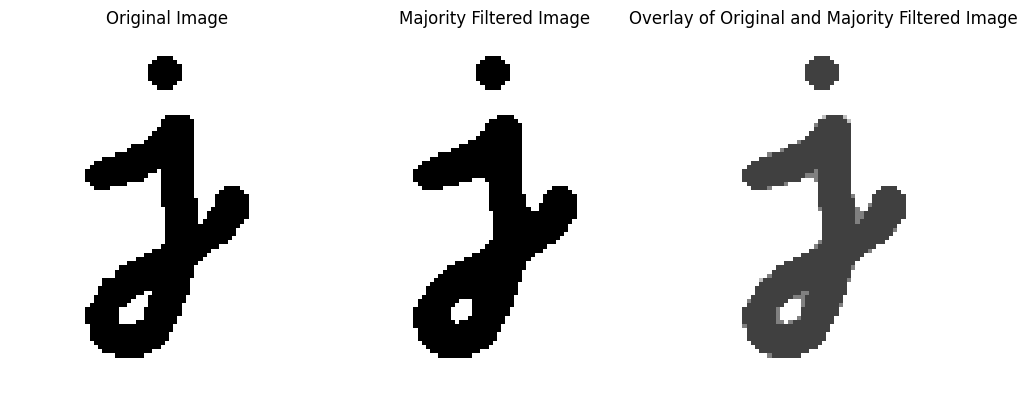

In [125]:
def majority(image, kernel, pad):
    padded_image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    output_image = np.zeros_like(image)
    s = kernel.shape[0] * kernel.shape[1]
    for i in range(pad, padded_image.shape[0] - pad):
        for j in range(pad, padded_image.shape[1] - pad):
            block = padded_image[i - pad:i + pad + 1, j - pad:j + pad + 1]
            c = np.sum(block * kernel)
            output_image[i - pad, j - pad] = threshold(c, s // 2)
    return output_image
# Perform majority filter
majority_image = majority(img, ker, pad)
majority_image = 1 - majority_image  # Re-invert the image for display purposes
# Display the majority filtered image vs original
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(1-img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(majority_image, cmap='gray')
plt.title('Majority Filtered Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(1-img, cmap='gray', alpha=0.5)
plt.imshow(majority_image, cmap='gray', alpha=0.5)
plt.title('Overlay of Original and Majority Filtered Image')
plt.axis('off')
plt.tight_layout()

(np.float64(-0.5), np.float64(74.5), np.float64(85.5), np.float64(-0.5))

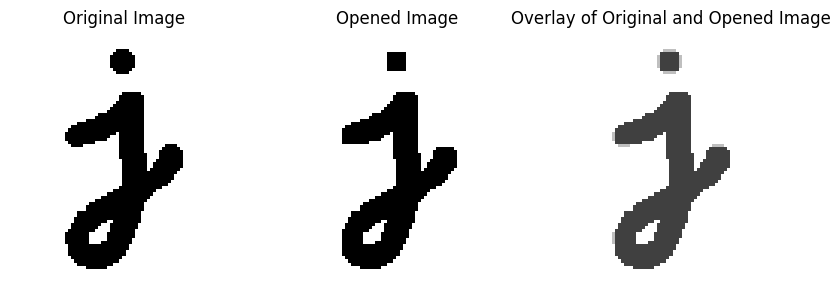

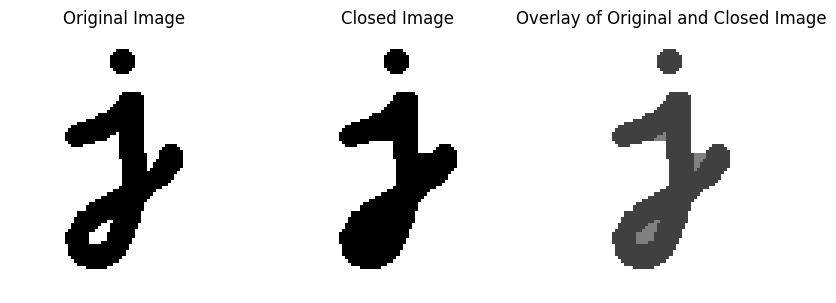

In [126]:
# opening = dialation(erosion))
def opening(image, kernel, pad):
    eroded = erosion(image, kernel, pad)
    opened = dialation(eroded, kernel, pad)
    return opened
# Perform opening
opened_image = opening(img, ker, pad)
opened_image = 1 - opened_image  # Re-invert the image for display purposes
# Display the opened image vs original
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(1-img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(opened_image, cmap='gray')
plt.title('Opened Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(1-img, cmap='gray', alpha=0.5)
plt.imshow(opened_image, cmap='gray', alpha=0.5)
plt.title('Overlay of Original and Opened Image')
plt.axis('off')
# closing = erosion(dilation))
def closing(image, kernel, pad):
    dilated = dialation(image, kernel, pad)
    closed = erosion(dilated, kernel, pad)
    return closed
# Perform closing
closed_image = closing(img, ker, pad)
closed_image = 1 - closed_image  # Re-invert the image for display purposes
# Display the closed image vs original
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(1-img, cmap='gray')
plt.title('Original Image')
plt.axis('off') 
plt.subplot(1, 3, 2)
plt.imshow(closed_image, cmap='gray')
plt.title('Closed Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(1-img, cmap='gray', alpha=0.5)
plt.imshow(closed_image, cmap='gray', alpha=0.5)
plt.title('Overlay of Original and Closed Image')
plt.axis('off')

### 🔁 Morphological Operations Summary (with $5 \times 5$ Kernel)

- **Dilation**: Grows object boundaries and fills small holes.  
  $$
  A \oplus B = \{ z \mid (B)_z \cap A \neq \emptyset \}
  $$

- **Erosion**: Shrinks objects and removes small noise.  
  $$
  A \ominus B = \{ z \mid (B)_z \subseteq A \}
  $$

- **Opening** \( A \circ B \): Erosion followed by dilation.  
  $$
  A \circ B = (A \ominus B) \oplus B
  $$
  Removes small objects (e.g., dot above 'j'), smooths contours, and breaks narrow connections.

- **Closing** \( A \bullet B \): Dilation followed by erosion.  
  $$
  A \bullet B = (A \oplus B) \ominus B
  $$
  Fills small holes, bridges narrow gaps, and connects nearby objects.

- **Majority**: Each pixel becomes 1 if the majority (more than half) of the pixels under the structuring element are 1.

  Useful for smoothing — rounds sharp corners while preserving general structure.

> **Note**: The size and shape of the structuring element  $S$ (here, $5 \times 5$ square) strongly affect all operations.


### Connected Components using Set union-find (disjoint data structure)

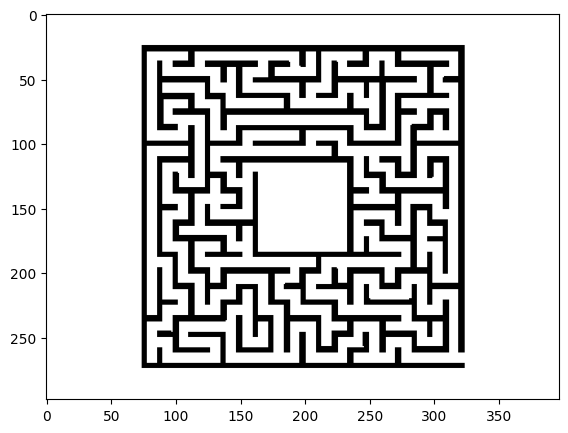

In [ ]:
img = cv2.imread('dat/maze.png', cv2.IMREAD_GRAYSCALE)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]
# downsample the image
ratio = 0.25
img = cv2.resize(img, (0, 0), fx=ratio, fy=ratio, interpolation=cv2.INTER_NEAREST)
plt.figure(figsize=(10, 5))
plt.imshow(img, cmap='gray')

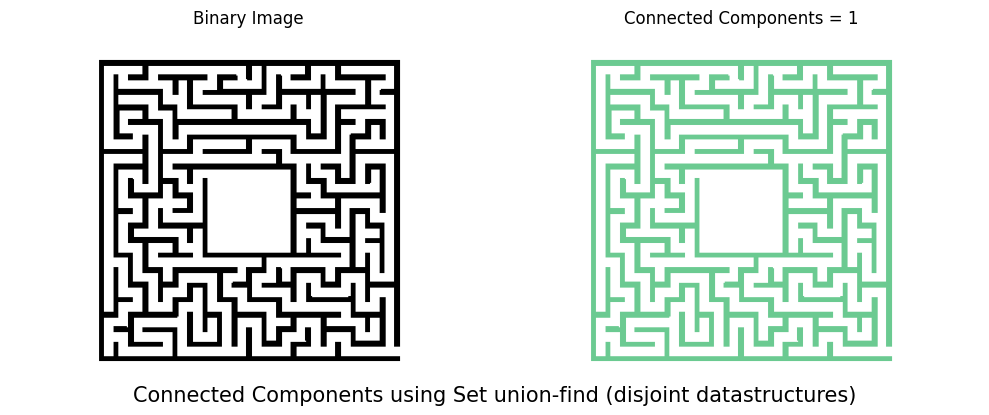

In [31]:
# we do N8 connectivity
img = img / np.max(img)  # Normalize to [0, 1]
sets = [] # list of sets
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if img[i, j] == 1:
            continue
        # top, left, top-left, top-right
        neighbors = [(i-1, j), (i, j-1), (i-1, j-1), (i-1, j+1)]
        # valid neighbors
        neighbors = [(x, y) for x, y in neighbors if 0 <= x < img.shape[0] and 0 <= y < img.shape[1] and img[x, y] == 0]
        if len(neighbors) == 0:
            # create a new set
            sets.append({(i, j)})
        else:
            # merge all the sets of the neighbors and add the current pixel to the merged set
            neighbor_sets = []
            for neighbor in neighbors:
                for s in sets:
                    if neighbor in s:
                        if s not in neighbor_sets:
                            neighbor_sets.append(s)
            # merge the sets with the 1st neighbor set
            if len(neighbor_sets) == 0:
                print(f"ERROR: pixel {i,j} has valid neighbors {neighbors} but no matching sets")
                raise Exception("Neighbor not found in any set")

            if len(neighbor_sets) == 1:
                neighbor_sets[0].add((i, j))
            else:
                for s in neighbor_sets[1:]:
                    neighbor_sets[0].update(s)
                    # remove s
                    sets.remove(s)
                neighbor_sets[0].add((i, j))

# output image in color
output_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) + 255
# Assign a unique color to each set
np.random.seed(14)  # Set random seed for color consistency
colors = np.random.randint(0, 255, (len(sets), 3), dtype=np.uint8)
for idx, s in enumerate(sets):
    color = colors[idx]
    for pixel in s:
        output_image[pixel[0], pixel[1]] = color
# Display the connected components image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Binary Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_image)    
plt.title(f'Connected Components = {len(sets)}')
plt.axis('off')
plt.tight_layout()
plt.figtext(0.5, 0.12, 'Connected Components using Set union-find (disjoint datastructures)',
             ha='center', fontsize=15)
plt.show()

